In [1]:
import pandas as pd
import numpy as np
import datetime
import gc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
from sklearn.model_selection import KFold
import lightgbm as lgb



In [2]:
building = pd.read_feather("building_metadata.feather")
train = pd.read_feather('train_new_2.feather')
weather = pd.read_feather("weather_train.feather")

In [3]:
train.head()


,building_id,meter,timestamp,meter_reading
0,105,0,2016-01-01 00:00:00,23.3036
1,106,3,2016-01-01 00:00:00,0.0000
2,108,0,2016-01-01 00:00:00,91.2653
3,109,0,2016-01-01 00:00:00,80.9300
4,109,3,2016-01-01 00:00:00,0.0000


In [4]:
building.head()


,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [6]:
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


In [7]:
building.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


In [8]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## Exploratory Data Analysis

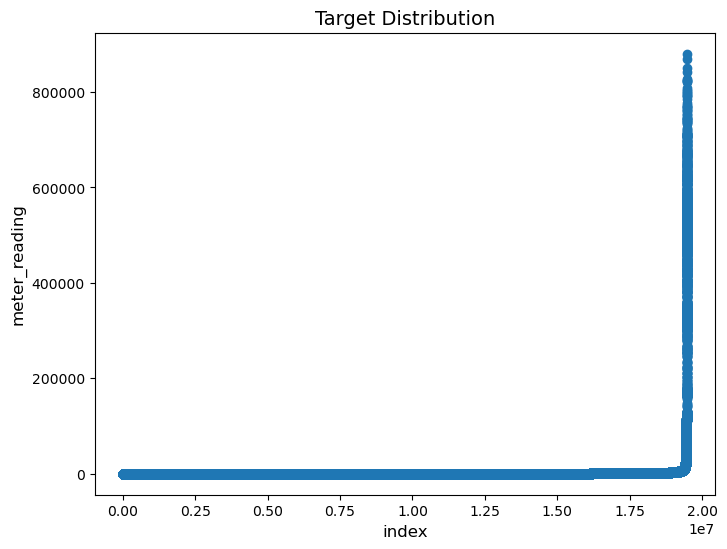

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train['meter_reading'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('meter_reading', fontsize=12)
plt.title("Target Distribution", fontsize=14)
plt.show()

<Axes: >

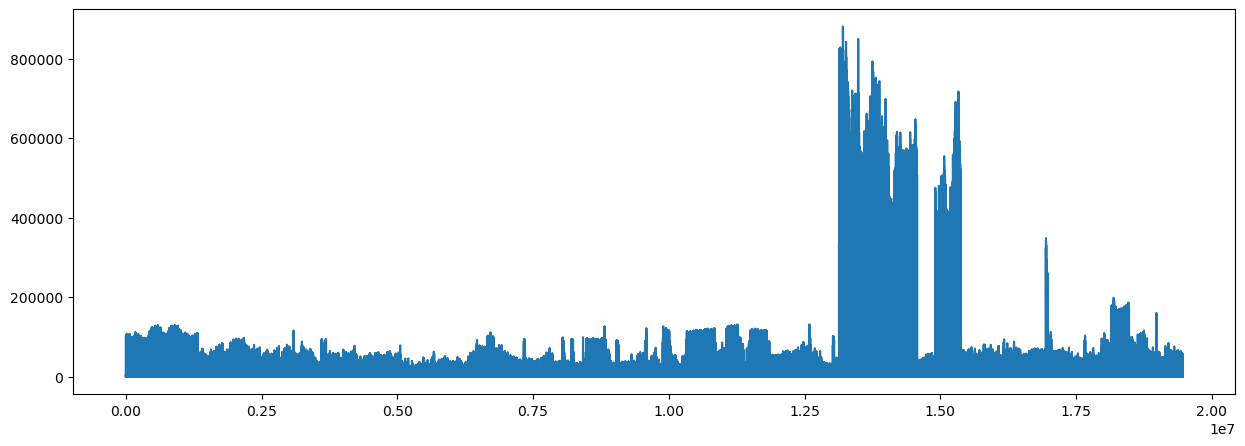

In [10]:
plt.figure(figsize = (15,5))
train['meter_reading'].plot()

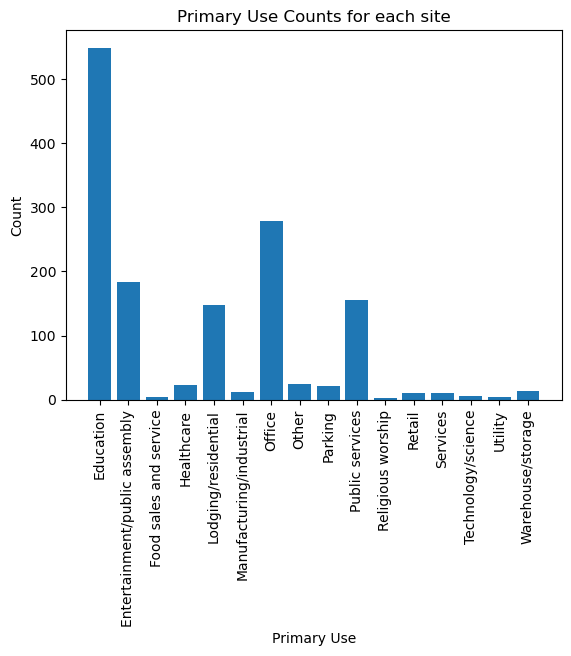

In [11]:
primary_use_counts = building.groupby("primary_use")["primary_use"].count()

# Create a bar chart of the primary use counts
plt.bar(primary_use_counts.index, primary_use_counts.values)

# Add chart title and axis labels
plt.title("Primary Use Counts for each site")
plt.xlabel("Primary Use")
plt.ylabel("Count")

plt.xticks(rotation=90)
# Show the chart
plt.show()

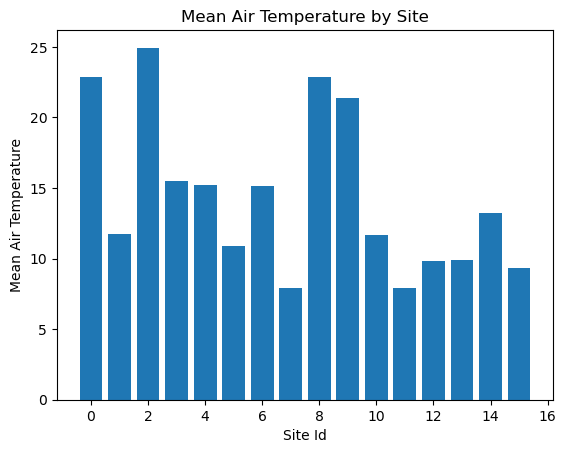

In [12]:
site_means = weather.groupby("site_id")["air_temperature"].mean()

# Create a bar chart of the site means
plt.bar(site_means.index, site_means.values)

# Add chart title and axis labels
plt.title("Mean Air Temperature by Site")
plt.xlabel("Site Id")
plt.ylabel("Mean Air Temperature")

# Show the chart
plt.show()

C:\Users\sweth\AppData\Local\Temp\ipykernel_22272\3204196221.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train.corr()['meter_reading'].sort_values()


Most Positive Correlations:
 building_id      0.040663
meter            0.076777
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 building_id      0.040663
meter            0.076777
meter_reading    1.000000
Name: meter_reading, dtype: float64


C:\Users\sweth\AppData\Local\Temp\ipykernel_22272\3204196221.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrs = weather.corr()


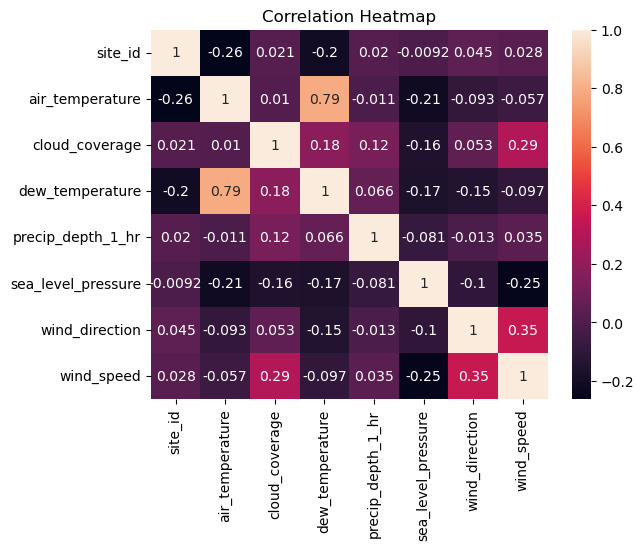

In [13]:
# Find correlations with the target and sort
correlations = train.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

corrs = weather.corr()
corrs


# Heatmap of correlations
sns.heatmap(corrs, annot = True)
plt.title('Correlation Heatmap');

## Data Preprocessing

In [14]:
def label_encoding(df,column_name): 
    
    """Label encoding column name from a data frame"""
    
    le = LabelEncoder()
    df[''+column_name+''] = le.fit_transform(df[''+column_name+''])


In [15]:
label_encoding(building,"primary_use")

In [16]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [17]:
def add_time_stamp_features(df,timestamp_colname):
    
    """Adding time stamp features"""
    
    df["datetime"] = pd.to_datetime(df[''+timestamp_colname+''])
    df["day"] = df["datetime"].dt.day
    df["week"] = df["datetime"].dt.week
    df["month"] = df["datetime"].dt.month

In [18]:
def weather_data_filler(df,column,by='mean'):
    
    """Filling data by mean/count/min/max/mode"""
    
    if by=='mean':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[[''+column+'']].mean(),columns=[''+column+''])
    elif by=='count':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[[''+column+'']].count(),columns=[''+column+''])
    elif by=='min':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].min(),columns=[''+column+''])
    elif by=='max':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].max(),columns=[''+column+''])
    elif by=='mode':
        filler = pd.DataFrame(df.groupby(['site_id','day','month'])[''+column+''].mode(),columns=[''+column+''])
    
    df.update(filler,overwrite=False)

In [19]:
def weather_data_filler_1(df,column,method='ffill',by='mean'):
    
    """Filling the NA values by forward fill and then by mean"""
    
    if by=='mean':
        filler = df.groupby(['site_id','day','month'])[''+column+''].mean()
    elif by=='count':
        filler = df.groupby(['site_id','day','month'])[''+column+''].count()
    elif by=='min':
        filler = df.groupby(['site_id','day','month'])[''+column+''].min()
    elif by=='max':
        filler = df.groupby(['site_id','day','month'])[''+column+''].max()
    elif by=='mode':
        filler = df.groupby(['site_id','day','month'])[''+column+''].mode()    
    
    filler = pd.DataFrame(filler.fillna(method=method),columns=[''+column+''])

    df.update(filler,overwrite=False)

In [20]:
def fill_weather_dataset_mean(weather_df):
    
    """Filling weather data by mean"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='mean')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='mean')

    weather_data_filler(weather_df,"dew_temperature",by='mean')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='mean')

    weather_data_filler(weather_df,"wind_direction",by='mean')

    weather_data_filler(weather_df,"wind_speed",by='mean')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='mean')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [21]:
def fill_weather_dataset_max(weather_df):
    
    
    """Filling weather data NA values by max"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='max')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='max')

    weather_data_filler(weather_df,"dew_temperature",by='max')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='max')

    weather_data_filler(weather_df,"wind_direction",by='max')

    weather_data_filler(weather_df,"wind_speed",by='max')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='max')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df


In [22]:
def fill_weather_dataset_min(weather_df):
    
    """Filling weather data NA values by min"""
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True)           

    # Add new timestamp Features 
    add_time_stamp_features(weather_df,"timestamp")
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    weather_data_filler(weather_df,"air_temperature",by='min')
    
    
    weather_data_filler_1(weather_df,"cloud_coverage",method='ffill',by='min')

    weather_data_filler(weather_df,"dew_temperature",by='min')

    weather_data_filler_1(weather_df,"sea_level_pressure",method='ffill',by='min')

    weather_data_filler(weather_df,"wind_direction",by='min')

    weather_data_filler(weather_df,"wind_speed",by='min')
    
    weather_data_filler_1(weather_df,"precip_depth_1_hr",method='ffill',by='min')
    
    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [23]:
weather_fill = fill_weather_dataset_mean(weather)
weather_fill.head()

C:\Users\sweth\AppData\Local\Temp\ipykernel_22272\894093638.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["week"] = df["datetime"].dt.week


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.000000,20.0,-0.173913,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,4.285714,21.1,-1.000000,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.000000,21.1,0.000000,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.000000,20.6,0.000000,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.000000,20.0,-1.000000,1020.0,250.0,2.6


In [24]:
%%time
train = train.merge(building, left_on='building_id',right_on='building_id',how='left')

CPU times: total: 3.86 s
Wall time: 3.98 s


In [25]:
%%time
train = train.merge(weather_fill,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])

CPU times: total: 8.33 s
Wall time: 10.3 s


In [26]:
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,105,0,2016-01-01 00:00:00,23.3036,1,0,50623,NaN,5.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
1,106,3,2016-01-01 00:00:00,0.0000,1,0,5374,NaN,4.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
2,108,0,2016-01-01 00:00:00,91.2653,1,0,81580,1913.0,5.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
3,109,0,2016-01-01 00:00:00,80.9300,1,0,56995,1953.0,6.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1
4,109,3,2016-01-01 00:00:00,0.0000,1,0,56995,1953.0,6.0,3.8,0.0,2.4,0.0,1020.9,240.0,3.1


In [27]:
len(train)

19464335

In [28]:
def log_transform(df,column):
    
    """Log Transformation of dataframe column"""
    df[''+column+''] =  np.log1p(df[''+column+''])
    
    
def log_transform_1(df,column):
    
    """Returning Log Transformation of dataframe column"""
    return np.log1p(df[''+column+''])
def drop_site_0(df):
    
    """Dropping inconsistent columns mentioned in the discussion"""
    df = df[(df.timestamp >= 3378) | (df.site_id != 0) | (df.meter != 0)]
def add_time_stamp_cols(df,time_stamp_col):
    
    """Adding time stamp columns"""
    
    df[''+time_stamp_col+'']=pd.to_datetime(df[''+time_stamp_col+''],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df[''+time_stamp_col+''].dt.hour
    df["weekend"] = df[''+time_stamp_col+''].dt.weekday
    
def add_new_features(df):
    
    """Adding Timestamp features, removing outliers and label encoding the primary_use column"""
    
    df['timestamp']=pd.to_datetime(df['timestamp'])
    
    df.timestamp = (df.timestamp - pd.to_datetime("2016-01-01")).dt.total_seconds() // 3600
    
    df.assign(tm_day_of_week=((df.timestamp // 24) % 7), tm_hour_of_day=(df.timestamp % 24))
    
    drop_site_0(df)
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    add_time_stamp_cols(df,"timestamp")
    
    log_transform(df,'square_feet')
    
     #Dropping electrical zeros
    df = df[(df["meter_reading"] > 0) | (df.meter != 0)]
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed","year_built","floor_count"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    # Encode Categorical Data
    label_encoding(df,"primary_use")
    
    return df


In [29]:
train_new = train

In [30]:
featured = add_new_features(train_new)


In [31]:
featured.head()


,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,105,0,23.3036,1,0,10.832181,3.8,0.0,2.4,0.0,0,3
1,106,3,0.0000,1,0,8.589514,3.8,0.0,2.4,0.0,0,3
2,108,0,91.2653,1,0,11.309352,3.8,0.0,2.4,0.0,0,3
3,109,0,80.9300,1,0,10.950736,3.8,0.0,2.4,0.0,0,3
4,109,3,0.0000,1,0,10.950736,3.8,0.0,2.4,0.0,0,3


In [32]:

target=log_transform_1(featured,"meter_reading")

features = featured.drop('meter_reading', axis = 1)


C:\Users\sweth\AppData\Local\Temp\ipykernel_22272\191372574.py:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(target, shade=True)


<Axes: xlabel='meter_reading', ylabel='Density'>

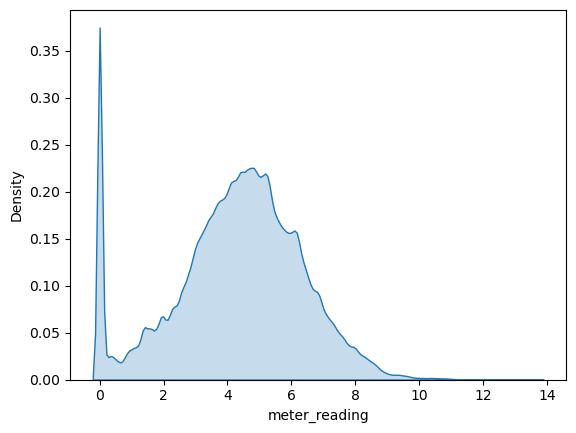

In [33]:
sns.kdeplot(target, shade=True)

In [34]:
features.head(10000)


,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,hour,weekend
0,105,0,1,0,10.832181,3.8,0.000000,2.4,0.0,0,3
1,106,3,1,0,8.589514,3.8,0.000000,2.4,0.0,0,3
2,108,0,1,0,11.309352,3.8,0.000000,2.4,0.0,0,3
3,109,0,1,0,10.950736,3.8,0.000000,2.4,0.0,0,3
4,109,3,1,0,10.950736,3.8,0.000000,2.4,0.0,0,3
...,...,...,...,...,...,...,...,...,...,...,...
10153,1137,1,13,6,10.220231,-7.2,2.666667,-10.6,0.0,0,3
10154,1138,0,13,0,10.596360,-7.2,2.666667,-10.6,0.0,0,3
10155,1139,0,13,6,12.726802,-7.2,2.666667,-10.6,0.0,0,3
10156,1139,1,13,6,12.726802,-7.2,2.666667,-10.6,0.0,0,3


# LGBM

In [35]:

def LGBM(categorical_features,params,splits,X,y):

    kf = KFold(n_splits=splits)
    models = []
    for train_index,test_index in kf.split(X):
        train_features = X.iloc[train_index]
        train_target = y.iloc[train_index]
        
        test_features = X.iloc[test_index]
        test_target = y.iloc[test_index]
        
        d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features)
        d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features)
        
        model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
        models.append(model)
        
        del train_features, train_target, test_features, test_target, d_training, d_test
        
        gc.collect()
    return models

In [36]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
     "num_leaves": 1280,
    "learning_rate": 0.05,
     "feature_fraction": 0.85,
     "reg_lambda": 2,
    "metric": "rmse",
}

model_LGBM=LGBM(categorical_features,params,3,features,target)

C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.445062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 12932826, number of used features: 10


C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.317472
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.991747	valid_1's rmse: 1.14251
[50]	training's rmse: 0.819946	valid_1's rmse: 1.03007
[75]	training's rmse: 0.788448	valid_1's rmse: 1.02376
[100]	training's rmse: 0.773038	valid_1's rmse: 1.02608
[125]	training's rmse: 0.761518	valid_1's rmse: 1.02853
Early stopping, best iteration is:
[79]	training's rmse: 0.78497	valid_1's rmse: 1.0236


C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 12932826, number of used features: 10


C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.243165
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.01437	valid_1's rmse: 1.08758
[50]	training's rmse: 0.844201	valid_1's rmse: 0.955466
[75]	training's rmse: 0.813335	valid_1's rmse: 0.938941
[100]	training's rmse: 0.797899	valid_1's rmse: 0.934781
[125]	training's rmse: 0.786368	valid_1's rmse: 0.934278
[150]	training's rmse: 0.777542	valid_1's rmse: 0.934686
Early stopping, best iteration is:
[118]	training's rmse: 0.789767	valid_1's rmse: 0.934177


C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.204361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 12932826, number of used features: 10


C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\sweth\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Start training from score 4.278799
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.992898	valid_1's rmse: 1.11688
[50]	training's rmse: 0.810465	valid_1's rmse: 1.00923
[75]	training's rmse: 0.775236	valid_1's rmse: 1.00483
[100]	training's rmse: 0.758379	valid_1's rmse: 1.00822
Early stopping, best iteration is:
[66]	training's rmse: 0.78384	valid_1's rmse: 1.00464


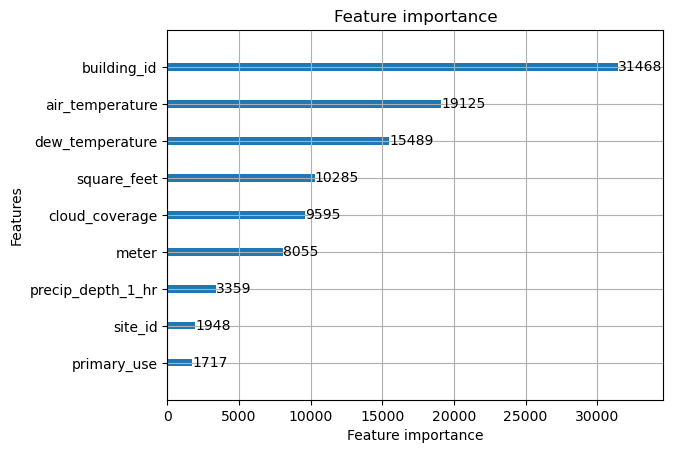

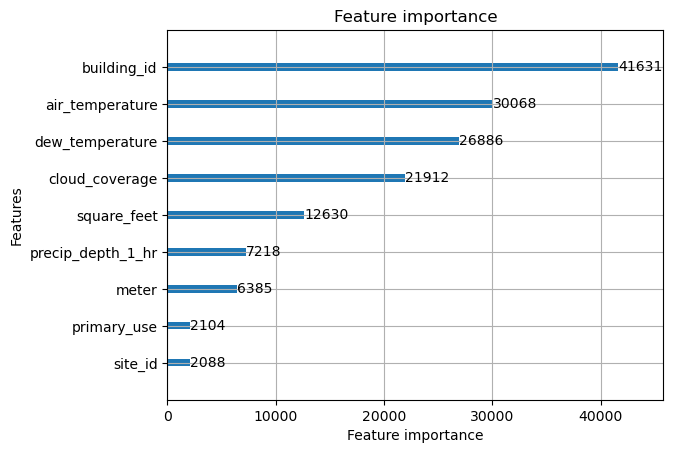

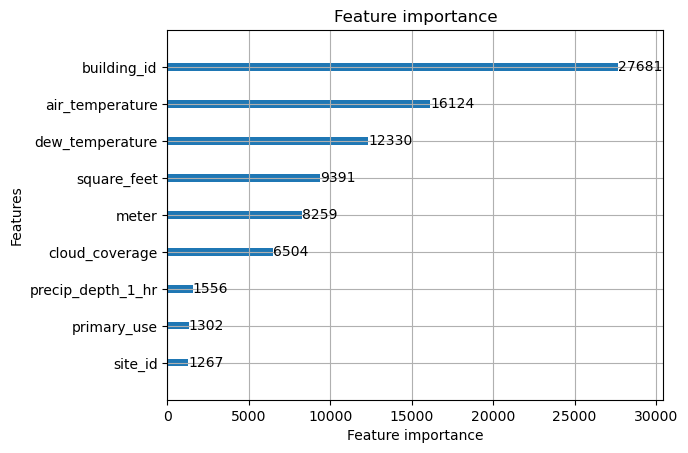

In [37]:
for model in model_LGBM:
    lgb.plot_importance(model)
    plt.show()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

# Halving Grid Search for best parameters



# Bayesian Optimization

In [ ]:
!conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV

search = BayesSearchCV(model, parameters, n_jobs=5)
search.fit(X_train,y_train)

print(search.best_params_)


In [41]:
%%time
results = []
for model in model_LGBM:
    if  results == []:
        results = model.predict(X_test, num_iteration=model.best_iteration) / len(model_LGBM)
    else:
        results += model.predict(X_test, num_iteration=model.best_iteration) / len(model_LGBM)
    del model

<timed exec>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
<timed exec>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


CPU times: total: 10min 51s
Wall time: 1min 44s


   ##   Linear Regression

In [42]:
def LinearRegression(X_train,y_train):
    
    """Implementing Linear Regression Algorithm"""
    
    from sklearn import linear_model
    mod = linear_model.LinearRegression()
    mod.fit(X_train, y_train)
    return mod

##  CatBoost


In [43]:
def CatBoost(X_train,y_train,categorical_features,num_iters,learning_rate,n_depth):
    
    """Implementing CatBoost Algorithm with learning_rate,depth of tree, 
    categorical features and number of iterations as parameters"""
    
    from sklearn.metrics import mean_squared_log_error
    from sklearn.metrics import mean_squared_error
    import catboost as cb
    from catboost import CatBoostRegressor


    model=CatBoostRegressor(iterations=num_iters, 
                        depth=n_depth, learning_rate=learning_rate, 
                        loss_function='RMSE')
    
   
    model.fit(X_train, y_train,cat_features=categorical_features)
    
    return model


In [44]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekend"]

cat_model=CatBoost(X_train,y_train,categorical_features,10,0.05,3)

0:	learn: 2.0153401	total: 8.41s	remaining: 1m 15s
1:	learn: 1.9805946	total: 12.5s	remaining: 50.2s
2:	learn: 1.9487174	total: 15s	remaining: 35s
3:	learn: 1.9194244	total: 16.6s	remaining: 24.9s
4:	learn: 1.8921354	total: 19s	remaining: 19s
5:	learn: 1.8668415	total: 20.6s	remaining: 13.7s
6:	learn: 1.8440239	total: 22.2s	remaining: 9.51s
7:	learn: 1.8227965	total: 23.9s	remaining: 5.98s
8:	learn: 1.8028509	total: 25.5s	remaining: 2.83s
9:	learn: 1.7845245	total: 27.1s	remaining: 0us


# XGBoost

In [45]:
def XGBoost(X_train,y_train,X_test,y_test,pars,Early_stopping_rounds):
    
    """Implementing XGBoost Algorithm with parameters and Early stop rounds as parameters"""
    
    import xgboost as xgb
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_eval = xgb.DMatrix(X_test, y_test)


    model = xgb.train(pars,
                      xgb_train,
                      num_boost_round=50,
                      evals=[(xgb_train, 'train'), (xgb_eval, 'val')],
                      verbose_eval=5,
                      early_stopping_rounds=Early_stopping_rounds
                     )
    return model


In [46]:
pars = {
    'colsample_bytree': 0.8,                 
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
}
XGB_model=XGBoost(X_train,y_train,X_test,y_test,pars,5)

[0]	train-rmse:3.93711	val-rmse:3.93737
[5]	train-rmse:2.69302	val-rmse:2.69316
[10]	train-rmse:2.04233	val-rmse:2.04247
[15]	train-rmse:1.73557	val-rmse:1.73569
[20]	train-rmse:1.57839	val-rmse:1.57861
[25]	train-rmse:1.50031	val-rmse:1.50051
[30]	train-rmse:1.44150	val-rmse:1.44161
[35]	train-rmse:1.41754	val-rmse:1.41768
[40]	train-rmse:1.39452	val-rmse:1.39462
[45]	train-rmse:1.37067	val-rmse:1.37075
[49]	train-rmse:1.35274	val-rmse:1.35276


# RESULTS

In [47]:
def all_results(test,pred):
    
    """This Method has all results with Mean Absolute Error, Root Mean Square Log Error 
    and Root Mean Squared Error"""
    
    test=np.abs(test)
    test=np.expm1(test)
    pred=np.abs(pred)
    pred=np.expm1(pred)
    
    step1=pred-test
    step2=np.power(step1,2).mean()
    step3_rmse=np.sqrt(step2)
    

    step1=np.array(test)-np.array(pred)
    step2=step1.mean()
    step3_mae=np.abs(step2)

    print(f'Root Mean Squared Loss Error is: {np.sqrt(mean_squared_log_error(test,pred))}')    
    print(f'Mean Absolute Error is: {step3_mae}')
    print(f'Root Mean Squared Error is: {step3_rmse}')   

In [48]:
def post_processing(model,X_train,y_train,X_test,y_test,Algorithm):
    
    """Implemented all post processing from predicting the test and test to printing results"""

    if Algorithm=='XGBoost':
        y_pred_train=model.predict(xgb.DMatrix(X_train))
        y_pred_test=model.predict(xgb.DMatrix(X_test))
        print("Train Results for XGBoost Model:")
        print("---------------------------------")
        all_results(y_pred_train,y_train)
        print("---------------------------------")
        print("Test Results for XGBoost Model:")
        print("---------------------------------")
        all_results(y_pred_test,y_test)
        print("---------------------------------")
    else:
        y_pred_train=model.predict(X_train)
        y_pred_test=model.predict(X_test)
        print(f"Train Results for {Algorithm} Model:")
        print("---------------------------------")
        all_results(y_pred_train,y_train)
        print("---------------------------------")
        print(f"Test Results for {Algorithm} Model:")
        print("---------------------------------")
        all_results(y_pred_test,y_test)
        print("---------------------------------")


In [49]:
post_processing(cat_model,X_train,y_train,X_test,y_test,Algorithm='CatBoost')

Train Results for CatBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7842083469085657
Mean Absolute Error is: 398.1112033190449
Root Mean Squared Error is: 4396.486154750742
---------------------------------
Test Results for CatBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7847991067243556
Mean Absolute Error is: 392.7239255307271
Root Mean Squared Error is: 4046.4792130090514
---------------------------------


In [50]:
linear=LinearRegression(X_train,y_train)
post_processing(linear,X_train,y_train,X_test,y_test,Algorithm='Linear Regression')

Train Results for Linear Regression Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7802844288627562
Mean Absolute Error is: 369.8518513339789
Root Mean Squared Error is: 4388.574623889853
---------------------------------
Test Results for Linear Regression Model:
---------------------------------
Root Mean Squared Loss Error is: 1.7814614544648362
Mean Absolute Error is: 364.43482416109833
Root Mean Squared Error is: 4037.9044928388876
---------------------------------


In [51]:
import xgboost as xgb
post_processing(XGB_model,X_train,y_train,X_test,y_test,Algorithm='XGBoost')

Train Results for XGBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.3527364558589117
Mean Absolute Error is: 312.7104792836382
Root Mean Squared Error is: 4293.922707029719
---------------------------------
Test Results for XGBoost Model:
---------------------------------
Root Mean Squared Loss Error is: 1.3527601338499917
Mean Absolute Error is: 307.2964850938931
Root Mean Squared Error is: 3935.7493978325665
---------------------------------


# PLOT RESULTS

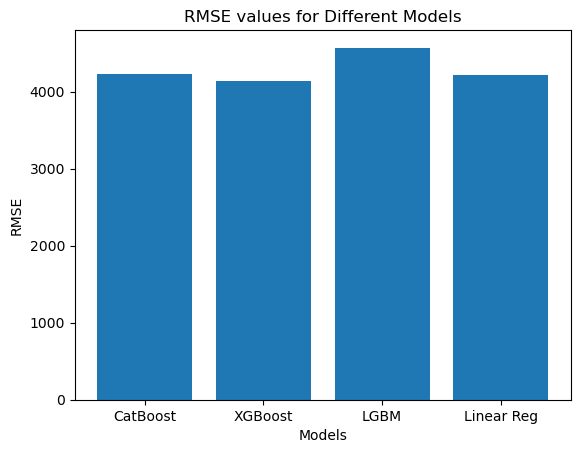

In [52]:
import matplotlib.pyplot as plt

# Replace these example RMSE values with the actual values for your models
CatBoost_rmse = 4229.6
XGBoost_rmse = 4134.2
LGBM_rmse = 4570.9
lineaReg_rmse = 4221.5

# Data for the bar chart
labels = ['CatBoost', 'XGBoost', 'LGBM', 'Linear Reg']
rmse_values = [CatBoost_rmse, XGBoost_rmse, LGBM_rmse, lineaReg_rmse]

# Create a bar chart
plt.bar(labels, rmse_values)

# Add labels and title
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE values for Different Models')

# Show the bar chart
plt.show()
